### Setup

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [7]:
def plot_series(time, series, format="-", start=0, end=None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)

### Trend and Seasonality

In [8]:
def trend(time, slope):
    return time * slope

Let's create a time series that just trends upward

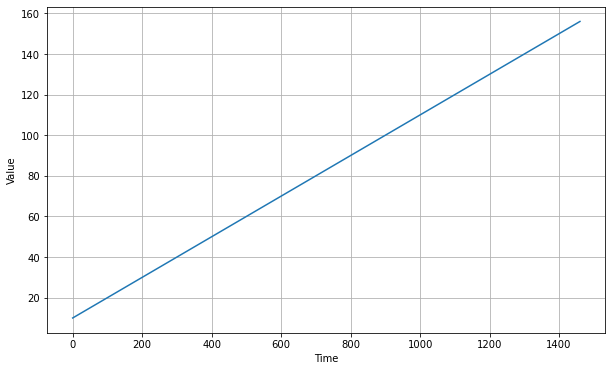

In [9]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time, 0.1)

plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [10]:
time

array([   0,    1,    2, ..., 1458, 1459, 1460])

In [11]:
series

array([ 10. ,  10.1,  10.2, ..., 155.8, 155.9, 156. ])

Now let's generate a time series with a seasonal pattern

In [12]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

### Naive Forecasting - Starts here

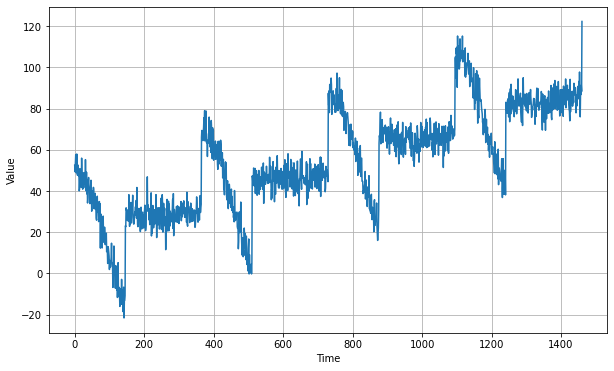

In [13]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

All right, this looks realistic enough for now. Let's try to forecast it. We will split it into two periods: the training period and the validation period (in many cases, you would also want to have a test period). The split will be at time step 1000.

In [14]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [15]:
# Naive Forcasting

In [16]:
naive_forecast = series[split_time - 1:-1]

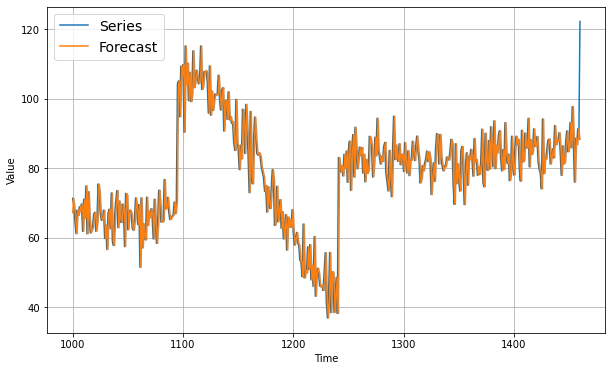

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, naive_forecast, label="Forecast")

Let's zoom in on the start of the validation period:

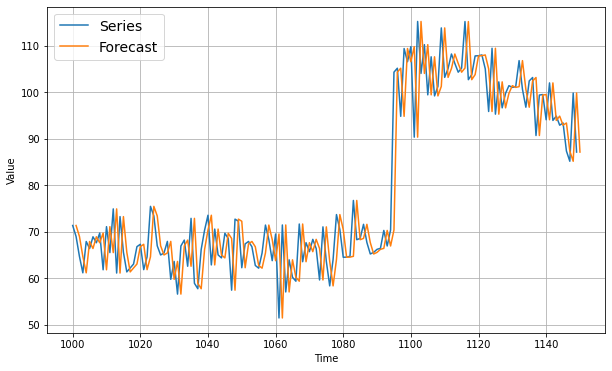

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

You can see that the naive forecast lags 1 step behind the time series.

Now let's compute the mean absolute error between the forecasts and the predictions in the validation period:

In [19]:
errors = naive_forecast - x_valid
abs_errors = np.abs(errors)
mae = abs_errors.mean()
mae

5.9379085153216735

That's our baseline, now let's try a moving average.

### Moving Average

In [20]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

In [21]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one"""
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

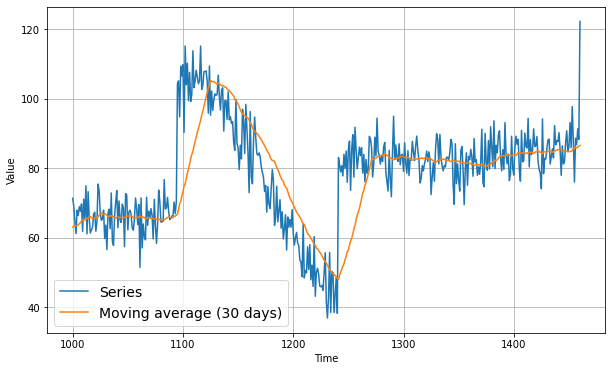

In [22]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

In [23]:
keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

7.1424185706207854

That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time t – 365 from the value at time t.

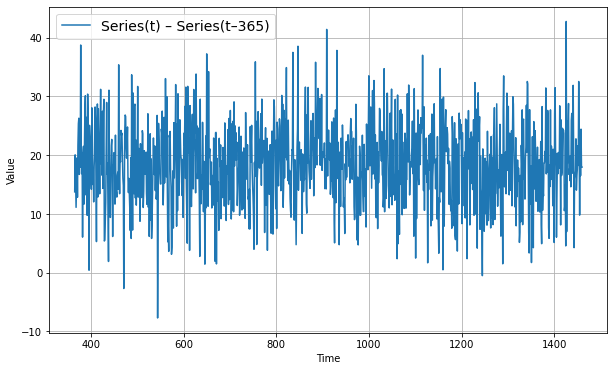

In [24]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label="Series(t) – Series(t–365)")
plt.show()

Focusing on the validation period:

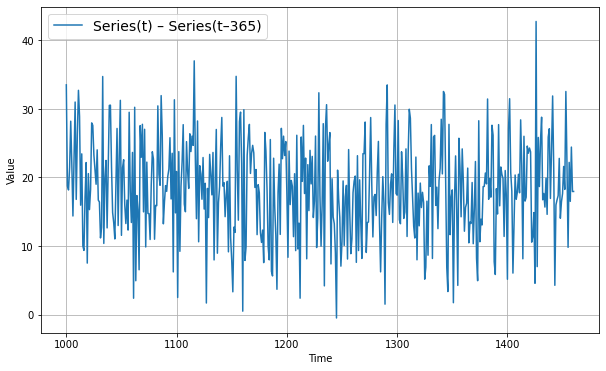

In [25]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plt.show()

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

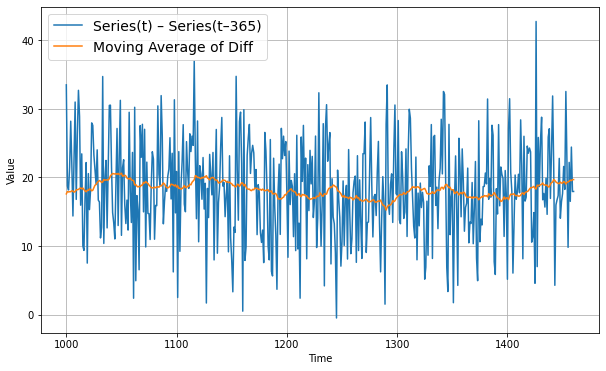

In [26]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plot_series(time_valid, diff_moving_avg, label="Moving Average of Diff")
plt.show()

Now let's bring back the trend and seasonality by adding the past values from t – 365:

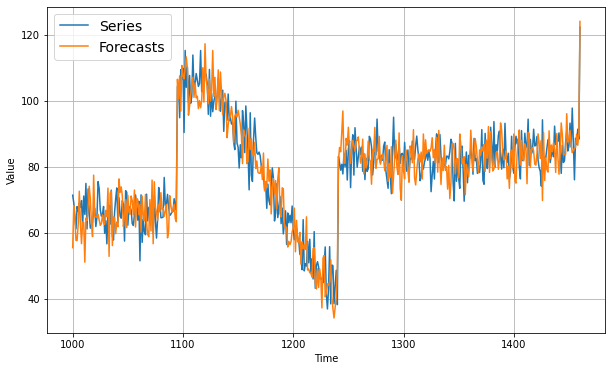

In [27]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_past, label="Forecasts")
plt.show()

In [28]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()

5.8393105629958955

Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

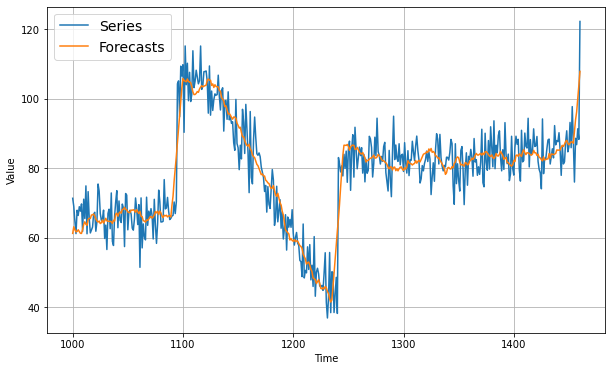

In [29]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()

In [30]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()

4.566859958970772

That's starting to look pretty good! Let's see if we can do better with a Machine Learning model.

### Forecasting with Machine Learning
First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [31]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [32]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

In [33]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 0s 6ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - lo

31/31 [==============================] - 0s 3ms/step - loss: 5.7668 - mae: 6.2473 - val_loss: 5.8891 - val_mae: 6.3675
Epoch 64/100
31/31 [==============================] - 0s 3ms/step - loss: 5.7735 - mae: 6.2540 - val_loss: 5.7918 - val_mae: 6.2716
Epoch 65/100
31/31 [==============================] - 0s 3ms/step - loss: 5.7196 - mae: 6.1992 - val_loss: 5.7822 - val_mae: 6.2677
Epoch 66/100
31/31 [==============================] - 0s 2ms/step - loss: 5.7195 - mae: 6.2001 - val_loss: 5.8370 - val_mae: 6.3169
Epoch 67/100
31/31 [==============================] - 0s 3ms/step - loss: 5.7116 - mae: 6.1953 - val_loss: 5.8026 - val_mae: 6.2866
Epoch 68/100
31/31 [==============================] - 0s 3ms/step - loss: 5.6455 - mae: 6.1273 - val_loss: 5.8970 - val_mae: 6.3825
Epoch 69/100
31/31 [==============================] - 0s 3ms/step - loss: 5.5995 - mae: 6.0752 - val_loss: 6.1008 - val_mae: 6.5871
Epoch 70/100
31/31 [==============================] - 0s 3ms/step - loss: 5.6110 - mae: 6

In [34]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 959us/step - loss: 67.6867 - mae: 68.1863
Epoch 2/100
31/31 [==============================] - 0s 866us/step - loss: 52.3572 - mae: 52.8561
Epoch 3/100
31/31 [==============================] - 0s 795us/step - loss: 34.6465 - mae: 35.1446
Epoch 4/100
31/31 [==============================] - 0s 744us/step - loss: 17.6521 - mae: 18.1484
Epoch 5/100
31/31 [==============================] - 0s 737us/step - loss: 8.4604 - mae: 8.9488
Epoch 6/100
31/31 [==============================] - 0s 719us/step - loss: 7.9765 - mae: 8.4627
Epoch 7/100
31/31 [==============================] - 0s 792us/step - loss: 7.9201 - mae: 8.4035
Epoch 8/100
31/31 [==============================] - 0s 779us/step - loss: 7.8785 - mae: 8.3609
Epoch 9/100
31/31 [==============================] - 0s 724us/step - loss: 7.8191 - mae: 8.3014
Epoch 10/100
31/31 [==============================] - 0s 764us/step - loss: 7.7701 - mae: 8.2547
Epoch 11/100
31/31 [===========

31/31 [==============================] - 0s 692us/step - loss: 16.4241 - mae: 16.9198
Epoch 86/100
31/31 [==============================] - 0s 675us/step - loss: 47.8956 - mae: 48.3930
Epoch 87/100
31/31 [==============================] - 0s 705us/step - loss: 21.6312 - mae: 22.1242
Epoch 88/100
31/31 [==============================] - 0s 724us/step - loss: 43.6849 - mae: 44.1834
Epoch 89/100
31/31 [==============================] - 0s 689us/step - loss: 27.7785 - mae: 28.2720
Epoch 90/100
31/31 [==============================] - 0s 677us/step - loss: 59.3580 - mae: 59.8542
Epoch 91/100
31/31 [==============================] - 0s 683us/step - loss: 38.3754 - mae: 38.8716
Epoch 92/100
31/31 [==============================] - 0s 703us/step - loss: 56.8195 - mae: 57.3180
Epoch 93/100
31/31 [==============================] - 0s 692us/step - loss: 40.1076 - mae: 40.6045
Epoch 94/100
31/31 [==============================] - 0s 700us/step - loss: 71.0130 - mae: 71.5114
Epoch 95/100
31/31 [===

(1e-06, 0.001, 0.0, 20.0)

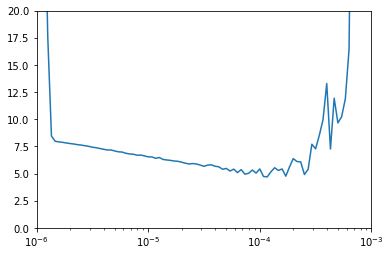

In [35]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [36]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 0s 5ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/500
31/31 [==============================] - 0s 3ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/500
31/31 [==============================] - 0s 3ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/500
31/31 [==============================] - 0s 3ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/500
31/31 [==============================] - 0s 3ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/500
31/31 [==============================] - 0s 3ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/500
31/31 [==============================] - 0s 3ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/500
31/31 [==============================] - 0s 3ms/step - lo

31/31 [==============================] - 0s 3ms/step - loss: 5.7668 - mae: 6.2473 - val_loss: 5.8891 - val_mae: 6.3675
Epoch 64/500
31/31 [==============================] - 0s 3ms/step - loss: 5.7735 - mae: 6.2540 - val_loss: 5.7918 - val_mae: 6.2716
Epoch 65/500
31/31 [==============================] - 0s 3ms/step - loss: 5.7196 - mae: 6.1992 - val_loss: 5.7822 - val_mae: 6.2677
Epoch 66/500
31/31 [==============================] - 0s 3ms/step - loss: 5.7195 - mae: 6.2001 - val_loss: 5.8370 - val_mae: 6.3169
Epoch 67/500
31/31 [==============================] - 0s 3ms/step - loss: 5.7116 - mae: 6.1953 - val_loss: 5.8026 - val_mae: 6.2866
Epoch 68/500
31/31 [==============================] - 0s 3ms/step - loss: 5.6455 - mae: 6.1273 - val_loss: 5.8970 - val_mae: 6.3825
Epoch 69/500
31/31 [==============================] - 0s 3ms/step - loss: 5.5995 - mae: 6.0752 - val_loss: 6.1008 - val_mae: 6.5871
Epoch 70/500
31/31 [==============================] - 0s 3ms/step - loss: 5.6110 - mae: 6

Epoch 125/500
31/31 [==============================] - 0s 3ms/step - loss: 4.7014 - mae: 5.1780 - val_loss: 5.0025 - val_mae: 5.4797
Epoch 126/500
31/31 [==============================] - 0s 3ms/step - loss: 4.6727 - mae: 5.1444 - val_loss: 4.9720 - val_mae: 5.4553
Epoch 127/500
31/31 [==============================] - 0s 3ms/step - loss: 4.6785 - mae: 5.1538 - val_loss: 4.9888 - val_mae: 5.4690
Epoch 128/500
31/31 [==============================] - 0s 3ms/step - loss: 4.6817 - mae: 5.1575 - val_loss: 4.8904 - val_mae: 5.3673
Epoch 129/500
31/31 [==============================] - 0s 3ms/step - loss: 4.6582 - mae: 5.1312 - val_loss: 4.9069 - val_mae: 5.3925
Epoch 130/500
31/31 [==============================] - 0s 3ms/step - loss: 4.6306 - mae: 5.0997 - val_loss: 4.9076 - val_mae: 5.3829
Epoch 131/500
31/31 [==============================] - 0s 3ms/step - loss: 4.7226 - mae: 5.1940 - val_loss: 4.9074 - val_mae: 5.3918
Epoch 132/500
31/31 [==============================] - 0s 3ms/step - 

31/31 [==============================] - 0s 3ms/step - loss: 4.4405 - mae: 4.9176 - val_loss: 4.9912 - val_mae: 5.4687
Epoch 187/500
31/31 [==============================] - 0s 3ms/step - loss: 4.3811 - mae: 4.8573 - val_loss: 4.8905 - val_mae: 5.3692
Epoch 188/500
31/31 [==============================] - 0s 3ms/step - loss: 4.4497 - mae: 4.9265 - val_loss: 4.5827 - val_mae: 5.0545
Epoch 189/500
31/31 [==============================] - 0s 3ms/step - loss: 4.5007 - mae: 4.9756 - val_loss: 4.7732 - val_mae: 5.2578
Epoch 190/500
31/31 [==============================] - 0s 3ms/step - loss: 4.3986 - mae: 4.8711 - val_loss: 4.8453 - val_mae: 5.3263
Epoch 191/500
31/31 [==============================] - 0s 3ms/step - loss: 4.3835 - mae: 4.8578 - val_loss: 4.6002 - val_mae: 5.0768
Epoch 192/500
31/31 [==============================] - 0s 3ms/step - loss: 4.3800 - mae: 4.8554 - val_loss: 4.7555 - val_mae: 5.2396
Epoch 193/500
31/31 [==============================] - 0s 3ms/step - loss: 4.3818 -

In [37]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [38]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

In [39]:
lin_forecast.shape

(461,)

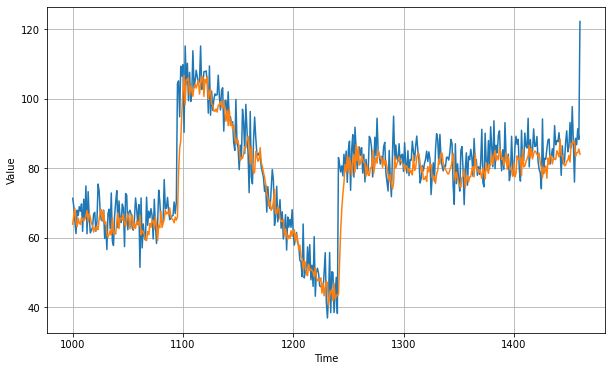

In [40]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [41]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.1662674

### Dense Model Forecasting

Copy of l08c06_forecasting_with_rnn.ipynb in Google drive

### Forecasing with Stateful RNNs

Copy of l08c07_forecasting_with_stateful_rnn.ipynb in Google drive

### Forecasting with Long Short Term Memory (LSTM) cells


Copy of l08c08_forecasting_with_lstm.ipynb

NOTE : GPU is must for a LSTM to run.

### Forecasting with CNNs

Copy of l08c09_forecasting_with_cnn.ipynb